# Laser Additive Manufacturing: Example Simulation

# Packages

In [1]:
%matplotlib inline

import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from IPython import display

# Input Parameters

In [2]:
# Input parameters:

# Plate Initialization:
x_length = 50/1000;               # [mm]-->[m]
y_length = 50/1000;               # [mm]-->[m]
nx = 200;                         # number of grid points
ny = 200;                         # number of grid points
#############################################################################
# Plate Properties: Sample Material: AISI Type 316L Stainless Steel

T0 = 300; 			              # Initial ambient temperature [K]
k = 15; 			              # conductivity coefficient [W/m/K]
cp = .5*1000; 			          # specific heat [J/g/c]-->[J/kg/K]
rho = 8*1000; 		              # density [g/cc]-->[kg/m^3]
Melt_Temp = 1670;                 # Melting point of material [k]
Est_Max_Temp = 2600;              # Estimated Max Temperature [K] (Should never exceed 3500 [K])
                                  # If White is seen on the Temperature Contour, Raise the Maximum Temperature
#############################################################################
# Laser Initialization:
q = 300; 			              # laser power [W]
Speed = 50/1000; 	              # laser speed x [mm/sec] --> [m/sec]
L_Rad = .7/1000;                  # Radius of the laser beam [mm] --> [m]
down_time  = .5;                  # time simulated added after laser is finished

# Inputs for Point guided laser:
HS_Path =[[-.005,0.015],[-.005,0],'stop',[.005,0.015],[.005,0],'stop',[-.015,-.005],[-.01,-.01],[.01,-0.01],[.015,-.005]];  
# Heat Source Points [x,y], [m]
path_stops = 2;               # the number of stops used
#############################################################################
# Simulation Options:

Sim_Type = 'Steps';              # Enter 'Steps' to see multiple frames of the simulation and 'Final' to see the final frame.

Sample_rate = 200;               # amount of samples collected per second
Frame_rate = 20;                 # Frames seen per second
Temp_Definition  = 200;          # Levels of temperature displayed on figure

# Generators and Functions

## Laser Path Generator

In [3]:
#For laser with point guided path
def Lazer_Path_Point(speed,Sample_rate,HS_Points,num_stops): #Turns a list of points into a list that describes laser movement
  total_time=0;                                              #per time step dt
  All_times = list();                            #Initialize all lists needed to complete calculations
  All_Distance = list();
  All_dx_dt = list();
  All_dy_dt = list();
  for p in range(len(HS_Points)-1):              #for each point-to-point path, calc change in x and y per change in time
    Point = HS_Points[p];
    Next_Point = HS_Points[p+1];
    if Point == 'stop':                          #if a stop appears, don't create a path to the next point
      dx_dt = 'stop';
      dy_dt = 'stop';
      time_elap = 0.0001;
      All_times.append(time_elap);               #Save the time taken to travel to the next point and save dy_dt,dx_dt
      All_dx_dt.append(dx_dt);
      All_dy_dt.append(dy_dt);
    elif (Next_Point== 'stop'):                  #If next point is stop, don't do anything extra
      null = None;                               #This stops extra data from being read
    else:
      dx = Next_Point[0]-Point[0];
      dy = Next_Point[1]-Point[1];
      Dist_Covered = np.sqrt((dx)**2+(dy)**2);
      time_elap = Dist_Covered/speed;
      dx_dt = dx/time_elap;
      dy_dt = dy/time_elap;
      All_Distance.append(Dist_Covered);          #Save the time taken to travel to the next point and save dy_dt,dx_dt
      All_times.append(time_elap);
      All_dx_dt.append(dx_dt);
      All_dy_dt.append(dy_dt);
  total_Time = sum(All_times);
  Data_points = int(np.floor(total_Time*Sample_rate)+num_stops); #Calc the number of data points needed
  Sim_dt = 1/Sample_rate;                                        #Calc the change in time per data point
  step = 1;
  current_path = 0;                                              #Set all initial values before the while loop
  time_elap = 0;
  u=0;
  xq_pre = HS_Points[0][0];
  yq_pre = HS_Points[0][1];
  All_xq_pos = np.array([xq_pre]);
  All_yq_pos = np.array([yq_pre]);
  while step < Data_points:
    path_time = All_times[current_path];              #set how long the current path will take
    if time_elap < path_time:                         #Make sure that the right path is being calculated
        null = None;
    else:
      current_path = current_path +1;                 #Update the path if needed
      time_elap = 0;
    for path in range(len(HS_Points)-1):              #for the path, calc the rate of change in position and
      if path == current_path:                        #the position of the laser per change in time
        x_rate = All_dx_dt[path];
        y_rate = All_dy_dt[path];
        if x_rate == 'stop':                          #if stop is passed, jump to the next point without making a path
          xq_pos =HS_Points[path+2+u][0];
          yq_pos =HS_Points[path+2+u][1];
          All_xq_pos = np.concatenate((All_xq_pos,np.array([xq_pos]))); #save the new position of the laser after the stop
          All_yq_pos = np.concatenate((All_yq_pos,np.array([yq_pos])));
          u = u +1;
        else:
          xq_pos = xq_pre + x_rate*Sim_dt;            #calculate the next position of the laser after t+dt time
          yq_pos = yq_pre + y_rate*Sim_dt;
          All_xq_pos = np.concatenate((All_xq_pos,np.array([xq_pos]))); #save the position after t+dt time
          All_yq_pos = np.concatenate((All_yq_pos,np.array([yq_pos])));
        xq_pre = xq_pos;
        yq_pre = yq_pos;                              #reset the previous position to use in the next loop
    if x_rate == 'stop':
      time_elap = time_elap + .0001;                  #if stop passes add arbitrary time to move the loop forward
    else:
      time_elap = time_elap + Sim_dt;                 #add the dt of the loop to the elapsed time and update the step
    step = step+1;
  return total_Time,Sim_dt,All_xq_pos,All_yq_pos,Data_points

## Mesh and Initial Value Generator 

In [4]:
#For Mesh and value initialization
[x,y] = np.meshgrid(np.linspace(-x_length/2,x_length/2,nx),np.linspace(-y_length/2,y_length/2,ny));  # Create a mesh for data collection

Max_Time,dt,xq_pos,yq_pos,Data_points = Lazer_Path_Point(Speed,Sample_rate,HS_Path,path_stops);  # Call the Path generator

alpha = k/(rho*cp);                                                     # initialize values needed for calculations
x_area = (x_length/nx)**2
y_area = (y_length/ny)**2
Frames_Used = int(round((Max_Time+down_time)*Frame_rate))               # initialize simulation settings and frame to data ratio n
After_Data_points = int(round(Sample_rate*down_time))
Total_Data_points = Data_points+After_Data_points;
n = int(round(Total_Data_points/Frames_Used));
Time = np.linspace(0,Max_Time+down_time,Data_points+After_Data_points); # make a time array that includes the down time
T = T0*np.ones((ny,nx));                                                # set the initial temperatue values of the plate mesh
T0_Mat = T0*np.ones((ny,nx));

## Calculation Functions

In [5]:
#Functions needed to complete calculations
def Diffusion(nx,ny,alpha,dt,x_area,y_area,T_pre,T):#calculates the diffusion through the mesh per dt
  diff_new = T;
  for i in range(1,ny-1,1):
    for j in range(1,nx-1,1):     # gauss seidel iteration
      diff_new[i][j]= (1/(1+2*alpha*dt*((1/x_area)+(1/y_area))))*(T_pre[i][j]+(alpha*dt)*(((T[i-1][j]+T[i+1][j])/x_area)+((T[i][j-1]+T[i][j+1])/y_area)));
  return diff_new

def Heat_Dist(nx,ny,t,alpha,rho,cp,dt,xq_pos,yq_pos,T_diff):#Calculates temperature distribution by gauss heat source per dt
  T_new = T_diff;
  for i in range(1,ny-1,1):
    for j in range(1,nx-1,1):
      q_dt = q*dt; #Laser strength [J]
      Denom_Out = 2*np.pi*rho*cp*((4*np.pi*alpha*dt)**(1/2))*(2*alpha*dt+L_Rad**2);
      Num_xy = ((x[i][j]-xq_pos[t-1])**2)+((y[i][j]-yq_pos[t-1])**2);
      Denom_xy = 4*alpha*dt + 2*(L_Rad**2);
      T_new[i][j] = T_diff[i][j] + ((q_dt)/Denom_Out)*np.exp(-(Num_xy/Denom_xy)); #calcs the temp at point i,j
  return T_new
    
def Melt_Bound(Melt_Temp,T,x,y): # Determines the area that is over the melting temperature and stores the boundary points
  Bound_x = [np.float64(x) for x in range(0)];
  Bound_y = [np.float64(x) for x in range(0)];
  for i in range(1,ny-1,1):
    for j in range(1,nx-1,1):
      if T[i][j]>Melt_Temp and T[i][j]<Melt_Temp*1.05: #checks the temperatue of the point
        Bound_x.append(x[i][j])
        Bound_y.append(y[i][j])
  Bound_x = np.array(Bound_x)
  Bound_y = np.array(Bound_y)
  return Bound_x,Bound_y

## Animation Functions

In [6]:
#Functions for Plotting:
Scale = 1;                       # figure window scale
Window_Pos = [0,0];              # Position of window from plate center (x,y) [m]
# Temperature Contour
def initialize_Plots(T0,q,k,cp,rho,T_Max,Temp_Definition,x_length,y_length,Window_Pos,Scale): #sets figure settings
  fig_Both,(axc,axp) = plt.subplots(1,2)
  fig_Both.set_figheight(6)
  fig_Both.set_figwidth(14)
  fig_Both.suptitle('Time Elapsed:')
  axc.set_aspect('equal', 'box')
  plt.rcParams.update({'text.color': "Black"})
  axc.set_title('Temperature Contour:')
  axc.set_xlabel('X [m]')
  axc.set_ylabel('Y [m]')
  axc.set_xlim((-((x_length/2)+Window_Pos[0])*Scale, ((x_length/2)+Window_Pos[0])*Scale));
  axc.set_ylim((-((y_length/2)+Window_Pos[1])*Scale, ((y_length/2)+Window_Pos[1])*Scale));
  plt.rcParams.update({'text.color': "white"})
  axc.text(0.01, 0.95,['v = ', str(Speed)], transform=axc.transAxes,fontsize=8);
  axc.text(0.01, 0.91,['T0= ', str(T0)], transform=axc.transAxes,fontsize=8);
  axc.text(0.01, 0.87,['q= ', str(q)], transform=axc.transAxes,fontsize=8);
  axc.text(0.01, 0.83,['k= ', str(k)], transform=axc.transAxes,fontsize=8);
  axc.text(0.01, 0.79,['cp= ', str(cp)], transform=axc.transAxes,fontsize=8);
  axc.text(0.01, 0.75,['rho= ', str(rho)], transform=axc.transAxes,fontsize=8);
  plt.rcParams.update({'text.color': "Black"})
  cvals = np.linspace(T0,T_Max,Temp_Definition)     # set contour values
  axp.set_aspect('equal', 'box')
  plt.rcParams.update({'text.color': "Black"})
  axp.set_title('Material Melted:')
  axp.set_xlabel('X [m]')
  axp.set_xlim((-((x_length/2)+Window_Pos[0])*Scale, ((x_length/2)+Window_Pos[0])*Scale));
  axp.set_ylim((-((y_length/2)+Window_Pos[1])*Scale, ((y_length/2)+Window_Pos[1])*Scale));
  return fig_Both,axc,axp,cvals

def plt_Both(Time,t,axc,axp,P_x,P_y,x,y,T,cvals,fig_Both,*,hdisplay): #plots both boundary and temp contours and updates fig
  fig_Both.suptitle(['Time Elapsed: ',str(round(Time[t],2))])
  T_cont = axc.contourf(x, y, T, cvals,cmap = cm.jet)
  if t == 0:
    cax = fig_Both.add_axes([axc.get_position().x1+0.005,axc.get_position().y0,0.01,axc.get_position().height])
    plt.colorbar(T_cont,cax=cax)
  Puddle = axp.scatter(P_x, P_y,c='red');
  hdisplay.update(fig_Both)
  return T_cont,Puddle

def plt_Contour(Time,t,axc,x,y,T,cvals,fig_Both,*,hdisplay): #plots only temp contour for cooldown phase
  fig_Both.suptitle(['(Cooling) Time Elapsed: ',str(round(Time[t],2))])
  axc.set_title('(Cooling) Temperature Contour:')
  T_cont = axc.contourf(x, y, T, cvals,cmap = cm.jet)
  if t == 0:
    cax = fig_Both.add_axes([axc.get_position().x1+0.005,axc.get_position().y0,0.01,axc.get_position().height])
    plt.colorbar(T_cont,cax=cax)
  hdisplay.update(fig_Both)
  return T_cont

# Function Calls: (Main)

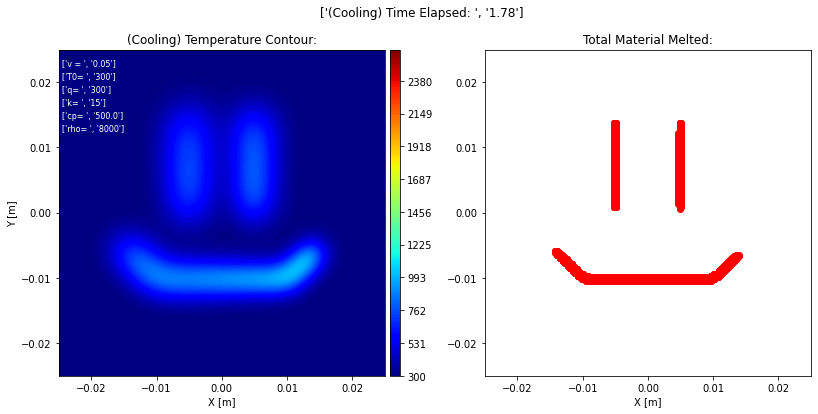

In [7]:
#Function calls
fig_Both,axc,axp,cvals = initialize_Plots(T0,q,k,cp,rho,Est_Max_Temp,Temp_Definition,x_length,y_length,Window_Pos,Scale)
hdisplay_Both = display.display("", display_id=True);
Store_X_B_final = np.array([]);
Store_Y_B_final = np.array([]);
Store_X_B = list();
Store_Y_B = list();
Store_T = list();
it = 0;
for t in range((Data_points-1)+ After_Data_points): #sets loop to calcuate and plot for each data point
  T_pre = T; # resets the previous Temp matrix
  if t<=Data_points-1:
    X_Bounds,Y_Bounds = Melt_Bound(Melt_Temp,T,x,y,); # calculate bound points for data point t
    if X_Bounds.size>0:
      Store_X_B_final = np.concatenate((Store_X_B_final,np.array(X_Bounds))); # store all bound points for final result
      Store_Y_B_final = np.concatenate((Store_Y_B_final,np.array(Y_Bounds)));
    if Sim_Type == 'Steps':
      if t % n == 0: #for every frame generated plot the temp contour and boundary points for data point t
        T_Cont,Puddle = plt_Both(Time,t,axc,axp,X_Bounds,Y_Bounds,x,y,T,cvals,fig_Both,hdisplay=hdisplay_Both)
        Puddle.remove()
        time.sleep(.0001)
        T_Cont.remove()
      if t == Data_points-1 or t == Data_points: # makes the final data point shown independent of frame ratio n
        T_Cont,Puddle = plt_Both(Time,t,axc,axp,X_Bounds,Y_Bounds,x,y,T,cvals,fig_Both,hdisplay=hdisplay_Both)
        Puddle.remove()
        time.sleep(.0001)
        T_Cont.remove()

    T_diff = Diffusion(nx,ny,alpha,dt,x_area,y_area,T_pre,T) #calls the diffusion function for data point t

    T = Heat_Dist(nx,ny,t,alpha,rho,cp,dt,xq_pos,yq_pos,T_diff) #calls the heat distribution function for data point dt

  if t> Data_points: # if greater than data points, enter the cooldown phase
    if Sim_Type == 'Steps':
      if it == 0:
        axp.set_title('Total Material Melted:')
        Puddle = axp.scatter(Store_X_B_final, Store_Y_B_final,c='red'); # plot all boundary points to show total melted material
        it = 1;
    if t % n == 0:
      if Sim_Type == 'Steps':
        T_Cont = plt_Contour(Time,t,axc,x,y,T,cvals,fig_Both,hdisplay=hdisplay_Both); # plot the next temp contour
    if t == (Data_points-1)+ After_Data_points-1:
      if Sim_Type == 'Steps':
        T_Cont = plt_Contour(Time,t,axc,x,y,T,cvals,fig_Both,hdisplay=hdisplay_Both); # plot final temp contour
        Puddle = axp.scatter(Store_X_B_final, Store_Y_B_final,c='red'); # plot all boundary points to show total melted material

    T_diff = Diffusion(nx,ny,alpha,dt,x_area,y_area,T_pre,T);
    if Sim_Type == 'Final':
      if t == (Data_points-1)+ After_Data_points-1:
        axp.set_title('Total Material Melted:')
        Puddle = axp.scatter(Store_X_B_final, Store_Y_B_final,c='red'); # plot all boundary points to show total melted material
        T_Cont = plt_Contour(Time,t,axc,x,y,T,cvals,fig_Both,hdisplay=hdisplay_Both); # plot final temp contour
plt.close()